<a href="https://colab.research.google.com/github/wangjb/cwb_open_data/blob/master/fcst_WRF_3km_24.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Prepare environment for pygrib and installation

In [ ]:
!sudo apt-get update
!sudo apt-get -qq install python-cartopy python3-cartopy
!sudo pip uninstall shapely
!sudo pip install shapely --no-binary shapely
!sudo apt-get install python3-grib

### Retrieve CWB FCST grib data

In [2]:
import urllib
import requests

def retrieve_data(datacode,auth):
  # query string to CWB open data service
  url='https://opendata.cwb.gov.tw/'
  sub_path='fileapi/v1/opendataapi/'
  # instant 10 min precip
  datalimit=''
  dataoffset=''
  dataformat='JSON'
  stationID=''
  datastatus=''

  # create query string
  url_path=url+sub_path+datacode
  query_fields=['Authorization','limit','offset','format','stationID','status']
  query_data=(auth,datalimit,dataoffset,dataformat,stationID,datastatus)
  query_string=dict(zip(query_fields,query_data))

  # request data
  r = requests.get(url_path,params=query_string,stream=True)
  jsondata = r.json()

  return jsondata

In [3]:
datacode = 'M-A0064-024'
auth = None
jsondata = retrieve_data(datacode, auth)

In [4]:
import pandas as pd
jsondata['cwbopendata']['dataset']['datasetInfo']['parameterSet']

[{'parameterName': 'Resolution', 'parameterValue': '3公里'},
 {'parameterName': 'Grids', 'parameterValue': '779334(1158*673)'},
 {'parameterName': 'Area', 'parameterValue': '區域'},
 {'parameterName': 'RunTime', 'parameterValue': '20200813 18Z'},
 {'parameterName': '預報時', 'parameterValue': '第024小時'},
 {'parameterName': '資料走向', 'parameterValue': '先橫軸西到東，再縱軸南到北'},
 {'parameterName': '資料起點',
  'parameterValue': '起點(1,1)位置為(14.02224°N,105.2500°E)，終點(1158,673)位置為(32.12021°N,140.91388°E)'}]

In [6]:
import subprocess
dataURL = jsondata['cwbopendata']['dataset']['resource']['uri']
subprocess.run(["wget",dataURL])

CompletedProcess(args=['wget', 'https://opendata.cwb.gov.tw/fileapi/opendata/MIC/M-A0064-024.grb2'], returncode=0)

In [40]:
import pygrib as pb
import os
datapath = subprocess.check_output(["pwd"],stderr=subprocess.STDOUT,shell=True).decode('ascii').replace('\n','/') + os.path.basename(dataURL)
grbs = pb.open(datapath)

### Inventory of the grib file

In [41]:
grbs.select()

[1:Geopotential Height:gpm (instant):lambert:isobaricInhPa:level 10000.0 Pa:fcst time 24 hrs:from 202008131800,
 2:Temperature:K (instant):lambert:isobaricInhPa:level 10000.0 Pa:fcst time 24 hrs:from 202008131800,
 3:U component of wind:m s**-1 (instant):lambert:isobaricInhPa:level 10000.0 Pa:fcst time 24 hrs:from 202008131800,
 4:V component of wind:m s**-1 (instant):lambert:isobaricInhPa:level 10000.0 Pa:fcst time 24 hrs:from 202008131800,
 5:Geometric vertical velocity:m s**-1 (instant):lambert:isobaricInhPa:level 10000.0 Pa:fcst time 24 hrs:from 202008131800,
 6:Relative humidity:% (instant):lambert:isobaricInhPa:level 10000.0 Pa:fcst time 24 hrs:from 202008131800,
 7:Geopotential Height:gpm (instant):lambert:isobaricInhPa:level 15000.0 Pa:fcst time 24 hrs:from 202008131800,
 8:Temperature:K (instant):lambert:isobaricInhPa:level 15000.0 Pa:fcst time 24 hrs:from 202008131800,
 9:U component of wind:m s**-1 (instant):lambert:isobaricInhPa:level 15000.0 Pa:fcst time 24 hrs:from 202008

### Plot WRF Surface Temp. data

In [62]:
surfaceTemp = grbs.select(parameterName='Temperature',typeOfLevel='surface')[0]

nx = surfaceTemp['Nx']
ny = surfaceTemp['Ny']
lat = surfaceTemp["latitudes"].reshape(ny,nx)
lon = surfaceTemp["longitudes"].reshape(ny,nx)
surfaceTempData = surfaceTemp['values'] - 273.15

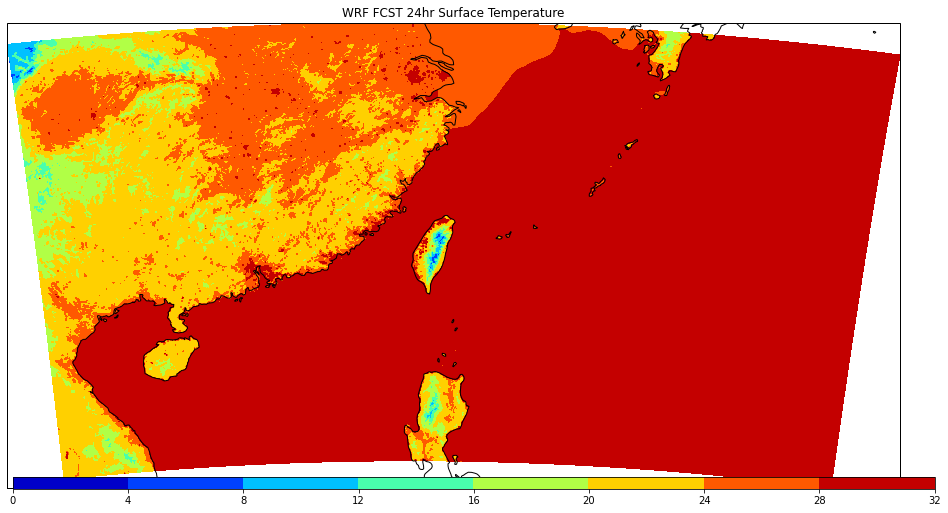

In [19]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors
import cartopy.io.shapereader as shpreader
from cartopy.feature import ShapelyFeature

fig = plt.figure(figsize=(16,16))
axes = plt.axes(projection=ccrs.PlateCarree())

land_50m = cfeature.NaturalEarthFeature(
    category='physical',
    name='land',
    scale='50m',
    edgecolor='k',
    facecolor='none'
    )

axes.add_feature(land_50m)

ctf = plt.contourf(lon,lat,surfaceTempData,cmap=plt.get_cmap('jet'))
axes.set_title("WRF FCST 24hr Surface Temperature")

cbaxes = fig.add_axes([0.13,0.3,0.8,0.01])
cbar = plt.colorbar(ctf,orientation="horizontal",cax=cbaxes)

fig.patch.set_facecolor('white')

plt.show()
plt.close()

In [153]:
surfaceTemp = grbs.select(parameterName='Temperature',typeOfLevel='surface')[0]

iy1, iy2, ix1, ix2 = [250,380,500,600]

nx = surfaceTemp['Nx']
ny = surfaceTemp['Ny']
lat = surfaceTemp["latitudes"].reshape(ny,nx)[iy1:iy2,ix1:ix2]
lon = surfaceTemp["longitudes"].reshape(ny,nx)[iy1:iy2,ix1:ix2]
surfaceTempData = surfaceTemp['values'][iy1:iy2,ix1:ix2] - 273.15

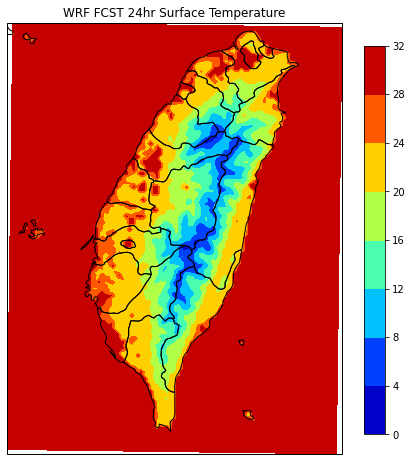

In [154]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors
import cartopy.io.shapereader as shpreader
from cartopy.feature import ShapelyFeature

clon = 121.76013
clat = 24.128498

lambert = ccrs.LambertConformal(
    central_longitude=clon,
    central_latitude=clat,
    standard_parallels=(10,40))

fig = plt.figure(figsize=(6,9))
axes = plt.axes(projection=lambert)

maps = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces',
    scale='10m',
    edgecolor='k',
    facecolor='none'
    )

axes.add_feature(maps)

ctf = plt.contourf(lon,lat,surfaceTempData,cmap=plt.get_cmap('jet'),transform=ccrs.PlateCarree())
axes.set_title("WRF FCST 24hr Surface Temperature")

cbaxes = fig.add_axes([0.95,0.2,0.05,0.6])
cbar = plt.colorbar(ctf,cax=cbaxes)

fig.patch.set_facecolor('white')

plt.show()
plt.close()

## Plot WRF total precip. data

In [170]:
totalprecip = grbs.select(parameterName='Total precipitation')[0]

iy1, iy2, ix1, ix2 = [250,380,500,600]

nx = totalprecip['Nx']
ny = totalprecip['Ny']
lat = totalprecip["latitudes"].reshape(ny,nx)[iy1:iy2,ix1:ix2]
lon = totalprecip["longitudes"].reshape(ny,nx)[iy1:iy2,ix1:ix2]
totalprecipData = totalprecip['values'][iy1:iy2,ix1:ix2]

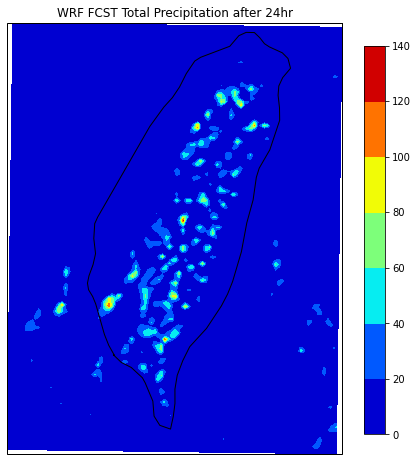

In [172]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors
import cartopy.io.shapereader as shpreader
from cartopy.feature import ShapelyFeature

clon = 121.76013
clat = 24.128498

lambert = ccrs.LambertConformal(
    central_longitude=clon,
    central_latitude=clat,
    standard_parallels=(10,40))

fig = plt.figure(figsize=(6,9))
axes = plt.axes(projection=lambert)

land_50m = cfeature.NaturalEarthFeature(
    category='physical',
    name='land',
    scale='50m',
    edgecolor='k',
    facecolor='none'
    )

axes.add_feature(land_50m)

ctf = plt.contourf(lon,lat,totalprecipData,cmap=plt.get_cmap('jet'),transform=ccrs.PlateCarree())
axes.set_title("WRF FCST Total Precipitation after 24hr")

cbaxes = fig.add_axes([0.95,0.2,0.05,0.6])
cbar = plt.colorbar(ctf,cax=cbaxes)

fig.patch.set_facecolor('white')

plt.show()
plt.close()

## Plot WRF Wind Field

In [227]:
wind10mU, wind10mV = grbs.select(shortName=['10u','10v'],level=10)

iy1, iy2, ix1, ix2 = [150,450,400,800]

nx = wind10mU['Nx']
ny = wind10mU['Ny']
lat = wind10mU["latitudes"].reshape(ny,nx)[iy1:iy2,ix1:ix2]
lon = wind10mU["longitudes"].reshape(ny,nx)[iy1:iy2,ix1:ix2]

wind10mUData = wind10mU['values'][iy1:iy2,ix1:ix2]
wind10mVData = wind10mV['values'][iy1:iy2,ix1:ix2]

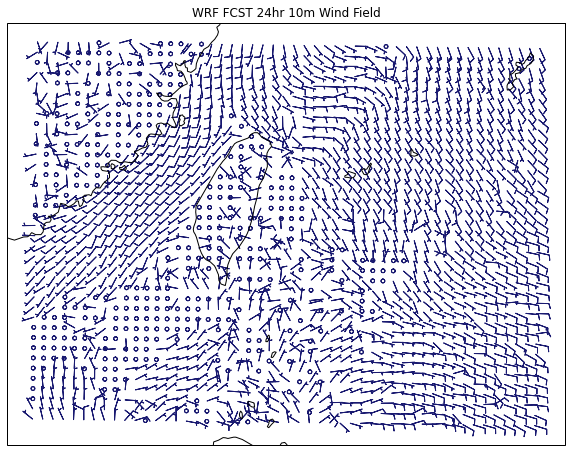

In [228]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors
import cartopy.io.shapereader as shpreader
from cartopy.feature import ShapelyFeature

clon = 121.76013
clat = 24.128498

lambert = ccrs.LambertConformal(
    central_longitude=clon,
    central_latitude=clat,
    standard_parallels=(10,40))

fig = plt.figure(figsize=(10,15))
axes = plt.axes(projection=lambert)

land_50m = cfeature.NaturalEarthFeature(
    category='physical',
    name='land',
    scale='50m',
    edgecolor='k',
    facecolor='none'
    )

axes.add_feature(land_50m)

npick = 8

plt.barbs(lon[::npick,::npick],lat[::npick,::npick],
      wind10mUData[::npick,::npick],wind10mVData[::npick,::npick],
      length=5, color="midnightblue", transform=ccrs.PlateCarree())

axes.set_title("WRF FCST 24hr 10m Wind Field")

fig.patch.set_facecolor('white')

plt.show()
plt.close()

## Plot WRF 24hr Relative Humidity

In [249]:
RH100hpa = grbs.select(parameterName='Relative humidity',level=100)[0]

iy1, iy2, ix1, ix2 = [50,600,100,1050]

nx = RH100hpa['Nx']
ny = RH100hpa['Ny']
lat = RH100hpa["latitudes"].reshape(ny,nx)[iy1:iy2,ix1:ix2]
lon = RH100hpa["longitudes"].reshape(ny,nx)[iy1:iy2,ix1:ix2]
print(RH100hpa["values"].shape)
RH100hpaData = RH100hpa['values'][iy1:iy2,ix1:ix2]
print(RH100hpaData.shape)

(673, 1158)
(550, 950)


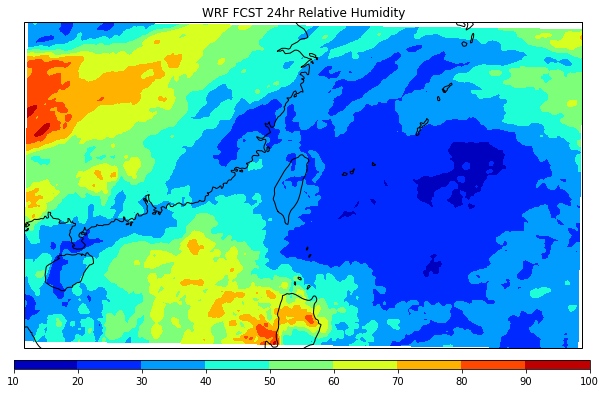

In [258]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors
import cartopy.io.shapereader as shpreader
from cartopy.feature import ShapelyFeature

clon = 121.76013
clat = 24.128498

lambert = ccrs.LambertConformal(
    central_longitude=clon,
    central_latitude=clat,
    standard_parallels=(10,40))

fig = plt.figure(figsize=(10,12))
axes = plt.axes(projection=lambert)

land_50m = cfeature.NaturalEarthFeature(
    category='physical',
    name='land',
    scale='50m',
    edgecolor='k',
    facecolor='none'
    )

axes.add_feature(land_50m)

ctf = plt.contourf(lon,lat,RH100hpaData,cmap=plt.get_cmap('jet'),transform=ccrs.PlateCarree())
axes.set_title("WRF FCST 24hr Relative Humidity")

cbaxes = fig.add_axes([0.11,0.29,0.8,0.01])
cbar = plt.colorbar(ctf,orientation="horizontal",cax=cbaxes)

fig.patch.set_facecolor('white')

plt.show()
plt.close()

### Plot WRF Geopotential Height @ 100hPa

In [281]:
gh100 = grbs.select(shortName='gh',level=100)[0]

iy1, iy2, ix1, ix2 = [50,600,100,1050]

nx = gh100['Nx']
ny = gh100['Ny']
lat = gh100["latitudes"].reshape(ny,nx)[iy1:iy2,ix1:ix2]
lon = gh100["longitudes"].reshape(ny,nx)[iy1:iy2,ix1:ix2]
print(gh100["values"].shape)
gh100Data = gh100['values'][iy1:iy2,ix1:ix2]
print(gh100Data.shape)

(673, 1158)
(550, 950)


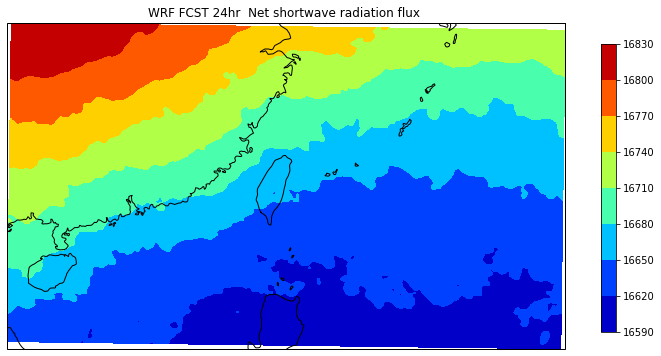

In [291]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors
import cartopy.io.shapereader as shpreader
from cartopy.feature import ShapelyFeature

clon = 121.76013
clat = 24.128498

lambert = ccrs.LambertConformal(
    central_longitude=clon,
    central_latitude=clat,
    standard_parallels=(10,40))

fig = plt.figure(figsize=(10,10))
axes = plt.axes(projection=lambert)

land_50m = cfeature.NaturalEarthFeature(
    category='physical',
    name='land',
    scale='50m',
    edgecolor='k',
    facecolor='none'
    )

axes.add_feature(land_50m)

ctf = plt.contourf(lon,lat,gh100Data,cmap=plt.get_cmap('jet'),transform=ccrs.PlateCarree())
axes.set_title("WRF FCST 24hr  Net shortwave radiation flux ")

cbaxes = fig.add_axes([0.95,0.3,0.02,0.4])
cbar = plt.colorbar(ctf,cax=cbaxes)

fig.patch.set_facecolor('white')

plt.show()
plt.close()